In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datos-precios-viviendas-y-mas-espaa/df_mineria_datos_vivienda.csv
/kaggle/input/datos-precios-viviendas-y-mas-espaa/datos_unidos_meses.csv
/kaggle/input/datos-precios-viviendas-y-mas-espaa/df_mineria_datos_edades.csv


In [35]:
df = pd.read_csv('/kaggle/input/datos-precios-viviendas-y-mas-espaa/datos_unidos_meses.csv')
df_edad = pd.read_csv('/kaggle/input/datos-precios-viviendas-y-mas-espaa/df_mineria_datos_edades.csv')
df_vivienda = pd.read_csv('/kaggle/input/datos-precios-viviendas-y-mas-espaa/df_mineria_datos_vivienda.csv')#le doy una variable pero para este estudio no voy a utilizar
#esta parte del dataset ya que da datos geograficos

In [36]:
print('INFORAMCION DE CADA DATASET A UTILIZAR Y PRIMERAS LINEAS')

print('datos unidos:')
print(df.info())
print(df.head())

print('datos edades:')
print(df_edad.info())
print(df_edad.head())

print(df.columns)


INFORAMCION DE CADA DATASET A UTILIZAR Y PRIMERAS LINEAS
datos unidos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   codigo_comunidad  1386 non-null   int64  
 1   comunidad         1386 non-null   object 
 2   name              1386 non-null   object 
 3   year              1386 non-null   object 
 4   precio            1386 non-null   float64
 5   IPC               1386 non-null   float64
 6   edad_media        1386 non-null   float64
 7   mano_obra         1386 non-null   float64
 8   precio_Acero      1386 non-null   float64
 9   precio_Aluminio   1386 non-null   float64
 10  precio_Cemento    1386 non-null   float64
 11  precio_Ceramica   1386 non-null   float64
 12  precio_Cobre      1386 non-null   float64
 13  precio_Energía    1386 non-null   float64
 14  precio_Ligantes   1386 non-null   float64
 15  precio_Madera     

In [37]:
#Editamos el dataset para hacerlo mas comodo para su uso

#revisamos elementos nulos y que no haya duplicados

print("\nMissing Values in Each Column:")
print(df.isnull().sum())


print("\nDuplicate Rows:", df.duplicated().sum())
df.drop_duplicates(inplace=True)


#convertimos el formato de la columan year a uno de date y ponemos 2 columnas con mes y año
df['year'] = pd.to_datetime(df['year'])
df['anho'] = df['year'].dt.year
df['month'] = df['year'].dt.month

#hacemos una nueva columna con el precio medio de todos los materiales para mas comodidad

df['precio_mats'] = df[['precio_Acero','precio_Aluminio','precio_Cemento','precio_Ceramica','precio_Cobre','precio_Energía','precio_Ligantes','precio_Madera']].mean(axis=1)




Missing Values in Each Column:
codigo_comunidad    0
comunidad           0
name                0
year                0
precio              0
IPC                 0
edad_media          0
mano_obra           0
precio_Acero        0
precio_Aluminio     0
precio_Cemento      0
precio_Ceramica     0
precio_Cobre        0
precio_Energía      0
precio_Ligantes     0
precio_Madera       0
num_hipotecas       0
num_inmigracion     0
dtype: int64

Duplicate Rows: 0


In [38]:
#comprobamos de nuevo el dataset y tambien revisamos cada columna
print('dataset editado')
print(df.info())
print(df.head())



dataset editado
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1386 entries, 0 to 1385
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   codigo_comunidad  1386 non-null   int64         
 1   comunidad         1386 non-null   object        
 2   name              1386 non-null   object        
 3   year              1386 non-null   datetime64[ns]
 4   precio            1386 non-null   float64       
 5   IPC               1386 non-null   float64       
 6   edad_media        1386 non-null   float64       
 7   mano_obra         1386 non-null   float64       
 8   precio_Acero      1386 non-null   float64       
 9   precio_Aluminio   1386 non-null   float64       
 10  precio_Cemento    1386 non-null   float64       
 11  precio_Ceramica   1386 non-null   float64       
 12  precio_Cobre      1386 non-null   float64       
 13  precio_Energía    1386 non-null   float64       
 14  precio_L

In [39]:
#comprobaciones estadisticas basicas

print('Summary statistics:')
print(df.describe())

Summary statistics:
       codigo_comunidad                           year       precio  \
count       1386.000000                           1386  1386.000000   
mean          10.277778  2012-07-01 05:36:37.402597376  1550.490620   
min            1.000000            2003-01-01 00:00:00   626.000000   
25%            6.000000            2007-10-01 00:00:00  1121.250000   
50%           10.500000            2012-07-01 00:00:00  1463.000000   
75%           15.000000            2017-04-01 00:00:00  1866.500000   
max           19.000000            2022-01-01 00:00:00  3267.000000   
std            5.497492                            NaN   533.627206   

               IPC   edad_media    mano_obra  precio_Acero  precio_Aluminio  \
count  1386.000000  1386.000000  1386.000000   1386.000000      1386.000000   
mean     89.448632    42.414603   375.498701   1082.185714       780.392208   
min      69.256000    33.832302   313.000000    717.400000       622.900000   
25%      84.303250    40

# Comparacion de varios datos segun comunidad 

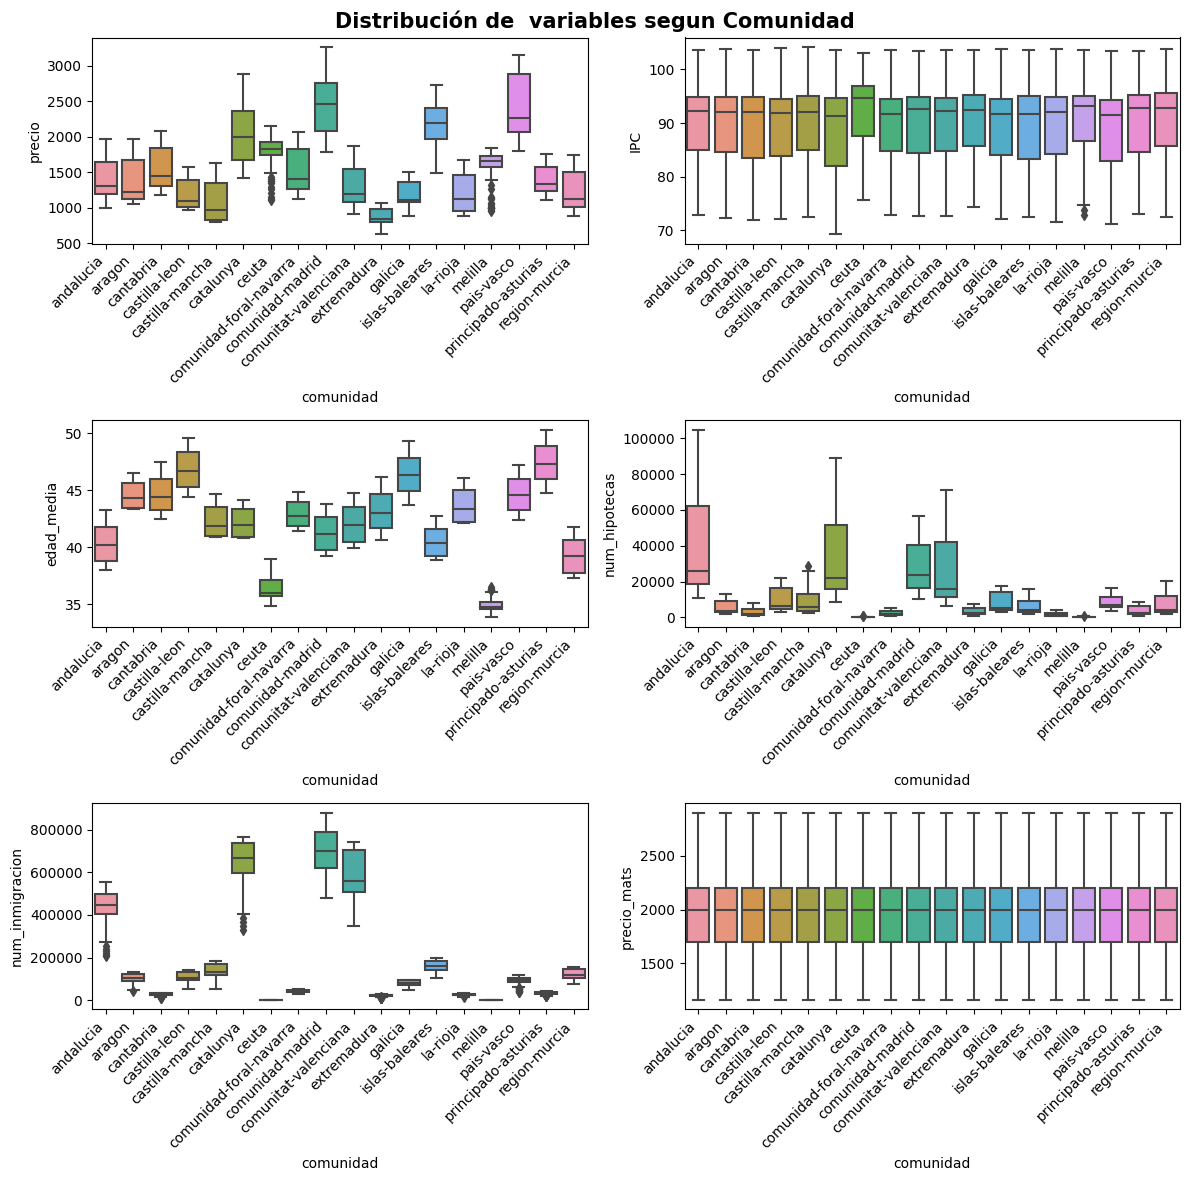

In [40]:
var1 = ['precio', 'IPC', 'edad_media', 'num_hipotecas', 'num_inmigracion', 'precio_mats']

fig, axes = plt.subplots(3, 2, figsize=(12, 4*3))

for i, var in enumerate(var1):
    row, col = divmod(i, 2)
    sns.boxplot(x='comunidad', y=var, data=df, ax=axes[row, col])
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45, ha='right')

for i in range(len(var1), len(axes)):
    fig.delaxes(axes[i])

fig.suptitle('Distribución de  variables segun Comunidad', fontweight='bold', fontsize=15)
plt.tight_layout()
plt.show()

Por lo que se puede observar tanto el ipc como los precios de los materiales no cambian mucho de una comunidad a otra mientras que la edad varia bastante,el precio segun se observa
es bastante constante en la mayoria de comunidades salvo en 4 donde se dispara:pais vasco,islas canarias y baleares,madrid y cataluña.Por ultimo podemos observar que la inmigracion es muy desigual
estando la gran mayoria en la comunidad valenciana

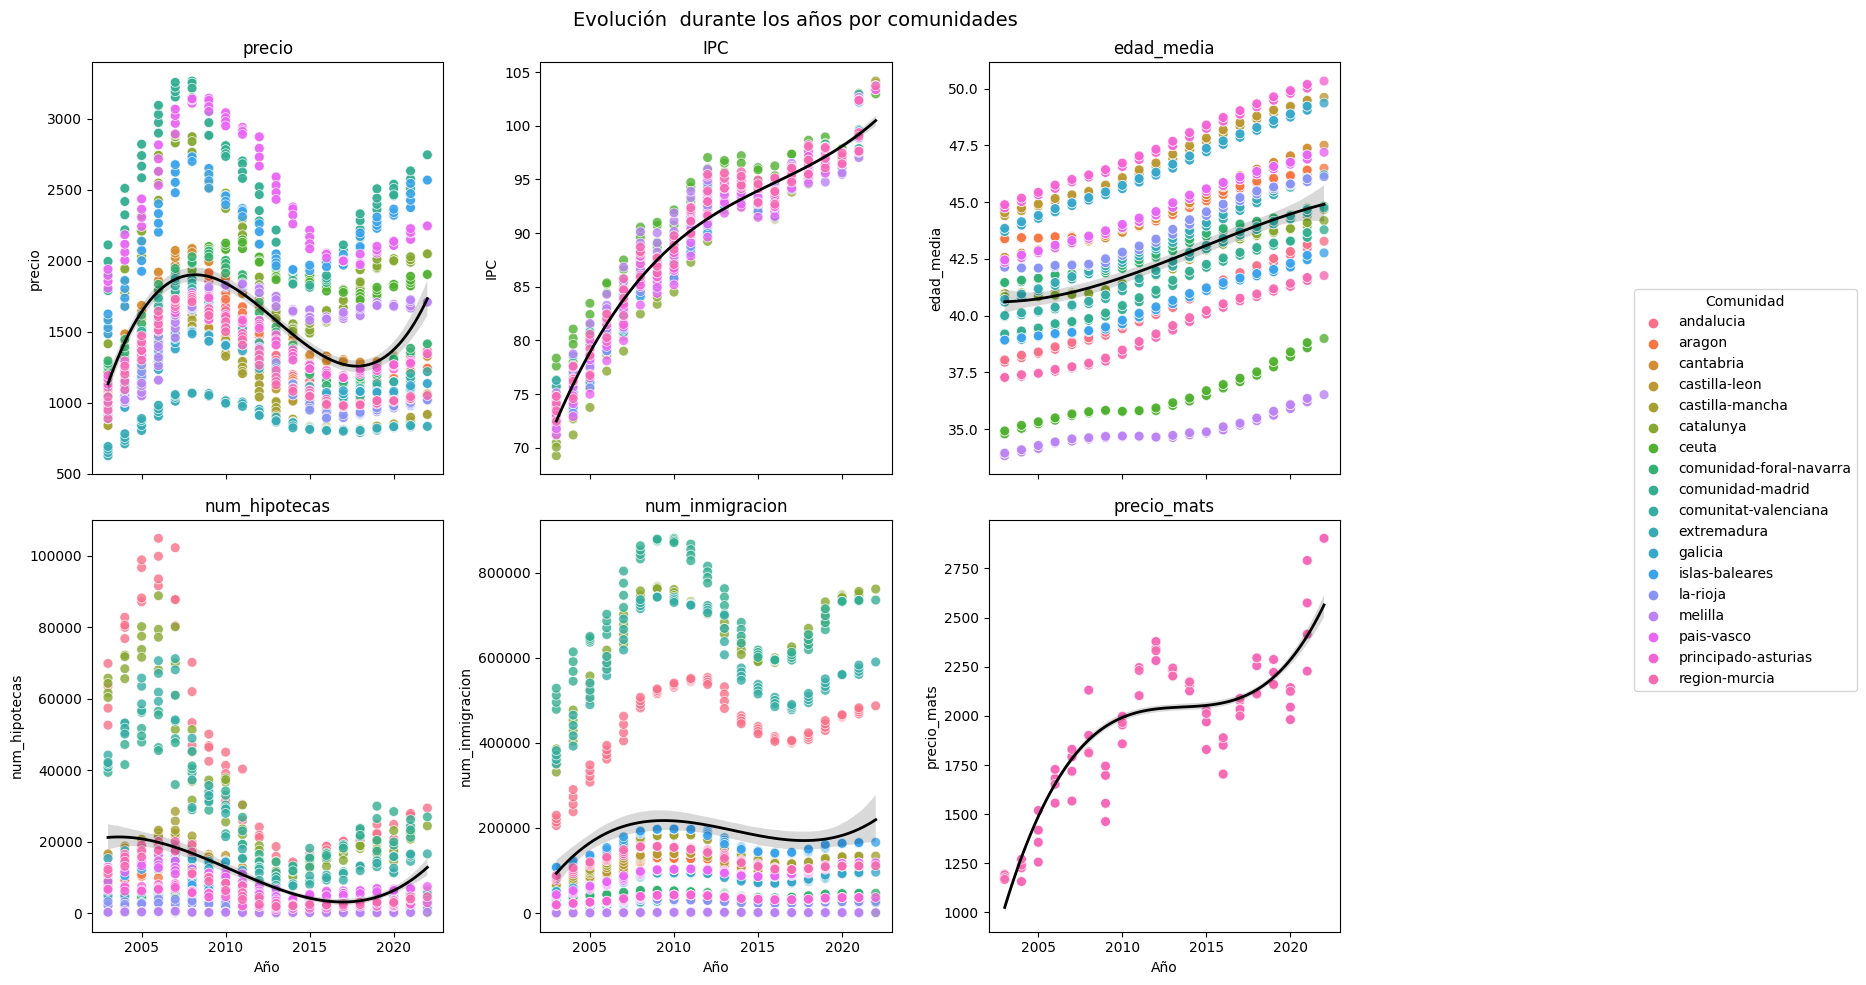

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

var1 = ['precio', 'IPC', 'edad_media', 'num_hipotecas', 'num_inmigracion','precio_mats']

fig, axes = plt.subplots(2, 3, figsize=(16, 10), sharex=True, sharey=False)

axes = axes.flatten()

scatter = sns.scatterplot(x='anho', y=var1[0], hue='comunidad', data=df, s=50, alpha=0.8, ax=axes[0])

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend_.remove() 

for i, var in enumerate(var1):
    ax = axes[i]
    sns.scatterplot(x='anho', y=var, hue='comunidad', data=df, s=50, alpha=0.8, ax=ax, legend=False)
    sns.regplot(x='anho', y=var, data=df, order=3, scatter=False, color='black', line_kws={'linewidth': 2}, ax=ax)
    
    ax.set_title(f"{var}")
    ax.set_xlabel("Año")
    ax.set_ylabel(var)

for i in range(len(var1), len(axes)):
    fig.delaxes(axes[i])

fig.legend(handles, labels, title="Comunidad", bbox_to_anchor=(1.02, 0.5), loc='center left')

plt.suptitle("Evolución  durante los años por comunidades", fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()

En estas graficas podemos observar como sobretodo en el 2010 hubo un aumento drastico tanto del precio coomo de la inmigracion aunque en los años sigueintes se normalizo,sin embargo el ipc y los precios
de los materiales no han dejado de subir en ningun momento
El numero de hipotecas tambein fue muy acusado entre 2005 y 2010 pero desde ahi ha bajado de forma drastica.
Ademas la edad media tamebin ha subido en todas las comunidades de forma constante aunque no de forma tan brusca como el ipc

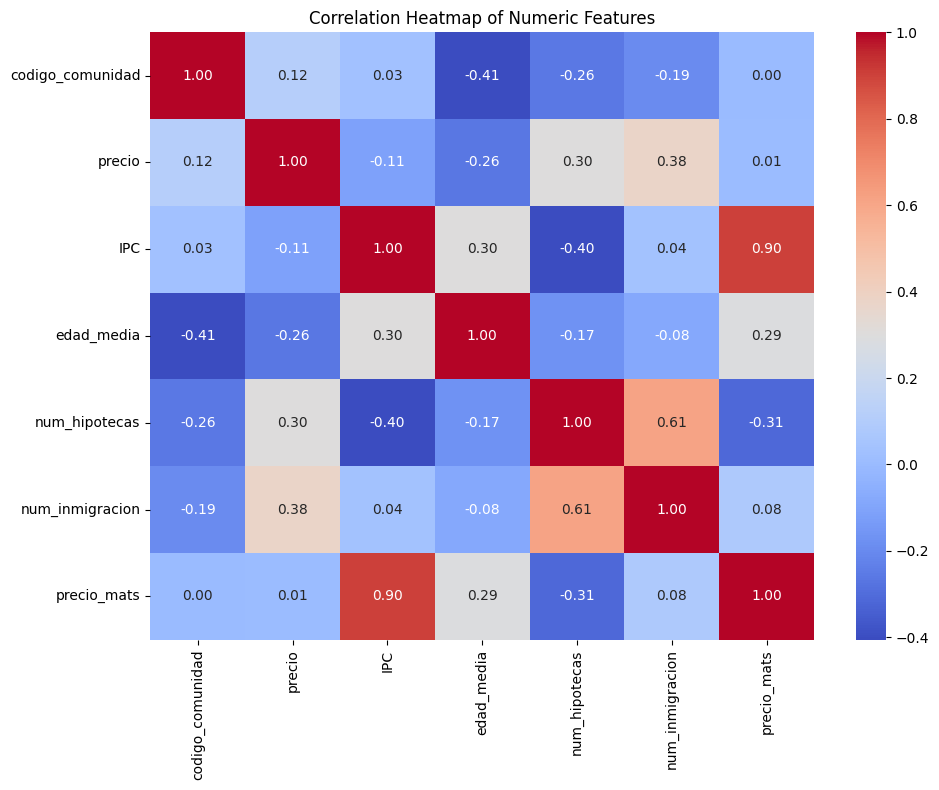

In [42]:
#mapa de correlacion


plt.figure(figsize=(10, 8))
num = df[['codigo_comunidad','precio', 'IPC', 'edad_media', 'num_hipotecas', 'num_inmigracion','precio_mats']].corr()
sns.heatmap(num, annot=True, cmap='coolwarm',fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()




# MODELO DE REGRESION LINEAL

In [43]:
#modelo predictivo

# Predictive Modeling for Income based on Key Variables
# Selecting relevant features
features = ['codigo_comunidad','IPC', 'edad_media', 'num_hipotecas', 'num_inmigracion','precio_mats']
target = 'precio'

df_filtered = df[features + [target]].dropna()  # Remove missing values

X = df_filtered[features]
y = df_filtered[target]

# Adding a constant for the intercept
X = sm.add_constant(X)

In [44]:
#modelo de regresion lineal

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 precio   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     82.95
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           8.88e-89
Time:                        05:57:53   Log-Likelihood:                -10456.
No. Observations:                1386   AIC:                         2.093e+04
Df Residuals:                    1379   BIC:                         2.096e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4126.1828    281.553  

Linear Regression Performance:
R2 Score: 0.30767305005829304
Mean Absolute Error: 388.0914786352365
Mean Squared Error: 207743.01679910757


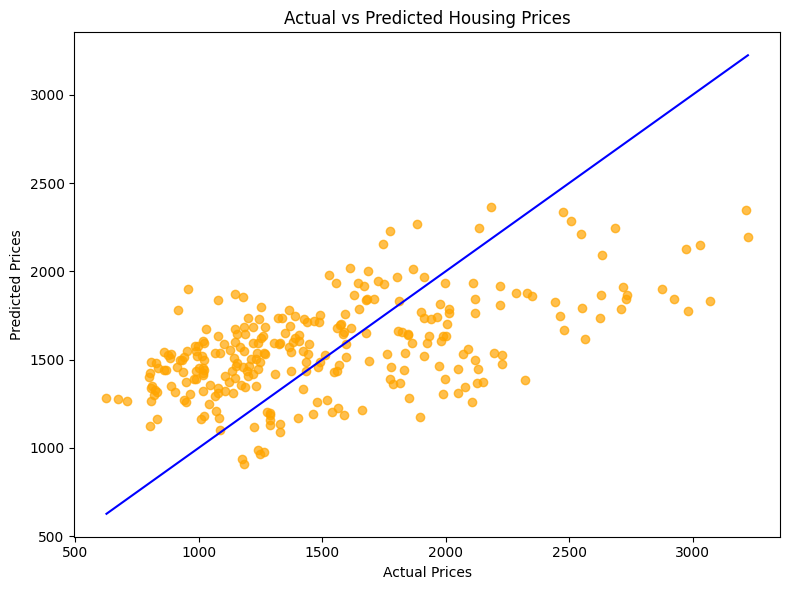

In [45]:
#modelo de regresion lineal con entreno de variables

# Predictive Modeling: Predicting Housing Prices

# For our simple linear regression, we select a set of predictive features.
# We remove non-numeric and identifier features.
features = ['codigo_comunidad','IPC','edad_media', 'mano_obra','num_hipotecas', 'num_inmigracion','precio_mats']

# Only select rows that have no missing values in the features and target columns
df_model = df.dropna(subset=features + ['precio'])

X = df_model[features]
y = df_model['precio']

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('Linear Regression Performance:')
print('R2 Score:', r2)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)

# Optionally, plot a scatter plot of predicted vs actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='orange')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Housing Prices')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='blue')
plt.tight_layout()
plt.show()

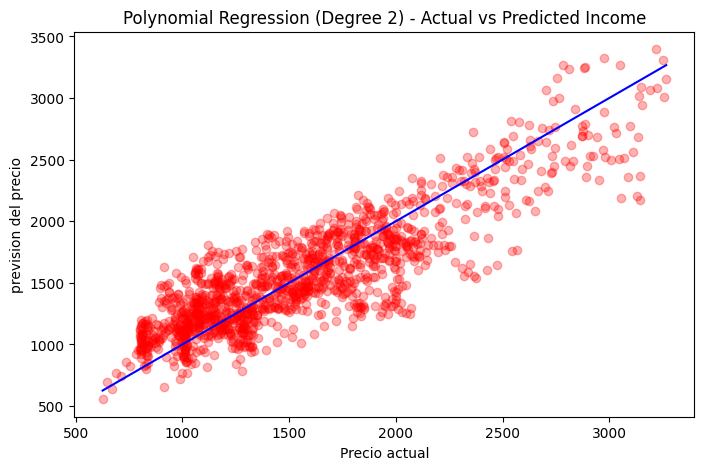

Polynomial Regression R² Score (Degree 2): 0.7478


In [46]:
# Define the polynomial degree
degree = 2  # Quadratic model

# Selecting the features for the polynomial regression
features_pol = ['codigo_comunidad','IPC','edad_media', 'mano_obra','num_hipotecas', 'num_inmigracion','precio_mats']
target_pol = 'precio'

df_filtered_pol = df[features_pol + [target_pol]].dropna()

X_pol = df_filtered_pol[features_pol]
y_pol = df_filtered_pol[target_pol]


# Create a polynomial regression model
pol_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model
pol_model.fit(X_pol, y_pol)

# Predict values
y_pol_pred = pol_model.predict(X_pol)

# Scatter plot of actual vs predicted income
plt.figure(figsize=(8, 5))
plt.scatter(y_pol, y_pol_pred, alpha=0.3, color="red")
plt.xlabel("Precio actual")
plt.ylabel("prevision del precio")
plt.title(f"Polynomial Regression (Degree {degree}) - Actual vs Predicted Income")
plt.plot([y_pol.min(), y_pol.max()], [y_pol.min(), y_pol.max()], color='blue')
plt.show()

# Model score (R-squared value)
pol_r2_score = pol_model.score(X_pol, y_pol)
print(f"Polynomial Regression R² Score (Degree {degree}): {pol_r2_score:.4f}")

# COMPARACION DE VARIOS ESTUDIOS A FUTURO DEL PRECIO

In [47]:
#comparacion de varios estudios
#vovlemos a crear una regresion polinomica sin grafica esta vez

degree = 2

features = ['codigo_comunidad','IPC','edad_media', 'mano_obra','num_hipotecas', 'num_inmigracion','precio_mats']
target = 'precio'

df_filter = df[features + [target]].dropna()

X = df_filter[features]
y = df_filter[target]




#creamos un modelo de regresion polinomica
pol_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Fit the model
pol_model.fit(X, y)
pol_r2 = pol_model.score(X, y)

In [48]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)
rf_r2 = rf_model.score(X, y)


In [49]:
# Gradient Boosting Model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X, y)
gb_r2 = gb_model.score(X, y)

In [50]:
# Feature Importance Analysis
rf_feature_importance = rf_model.feature_importances_
gb_feature_importance = gb_model.feature_importances_
# Convert feature importances into DataFrame
rf_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": rf_feature_importance})
gb_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": gb_feature_importance})

# Sort feature importances
rf_importance_df = rf_importance_df.sort_values(by="Importance", ascending=False)
gb_importance_df = gb_importance_df.sort_values(by="Importance", ascending=False)

# Print R² scores
print(f"Polynomial Regression R² Score: {pol_r2:.4f}")
print(f"Random Forest R² Score: {rf_r2:.4f}")
print(f"Gradient Boosting R² Score: {gb_r2:.4f}")

Polynomial Regression R² Score: 0.7478
Random Forest R² Score: 0.9982
Gradient Boosting R² Score: 0.9765


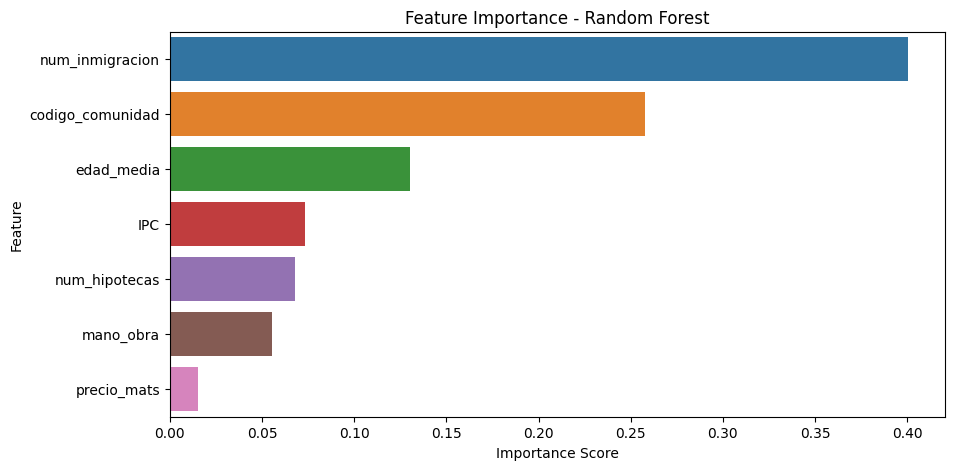

In [51]:
# Plot Feature Importance - Random Forest
plt.figure(figsize=(10, 5))
sns.barplot(x=rf_importance_df["Importance"], y=rf_importance_df["Feature"])
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

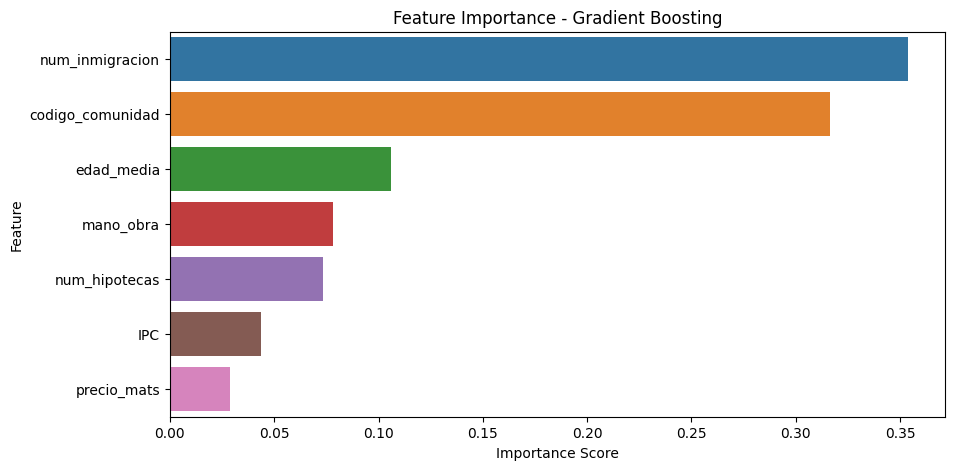

In [52]:
# Plot Feature Importance - Gradient Boosting
plt.figure(figsize=(10, 5))
sns.barplot(x=gb_importance_df["Importance"], y=gb_importance_df["Feature"])
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [53]:
# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [50, 100, 200],  # Reduce the number of trees
    "max_depth": [10, 20, None],  # Limit tree depth to prevent overfitting
    "min_samples_split": [2, 5, 10],  # Minimum samples required to split a node
    "min_samples_leaf": [1, 2, 4],  # Minimum samples required at a leaf node
}

# Define hyperparameter grid for Gradient Boosting
gb_param_grid = {
    "n_estimators": [50, 100, 200],  # Number of boosting stages
    "learning_rate": [0.01, 0.1, 0.2],  # Lower learning rate for better generalization
    "max_depth": [3, 5, 10],  # Depth of individual trees
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [54]:
# Grid Search for Random Forest
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, n_jobs=-1, scoring="r2")
rf_grid_search.fit(X_train, y_train)

# Grid Search for Gradient Boosting
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=3, n_jobs=-1, scoring="r2")
gb_grid_search.fit(X_train, y_train)

# Best parameters found
best_rf_model = rf_grid_search.best_estimator_
best_gb_model = gb_grid_search.best_estimator_

print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
print(f"Best Gradient Boosting Parameters: {gb_grid_search.best_params_}")

Best Random Forest Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Gradient Boosting Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [55]:
# Evaluate on the test set
rf_r2_tuned = best_rf_model.score(X_test, y_test)
gb_r2_tuned = best_gb_model.score(X_test, y_test)

print(f"Tuned Random Forest R² Score (Test Set): {rf_r2_tuned:.4f}")
print(f"Tuned Gradient Boosting R² Score (Test Set): {gb_r2_tuned:.4f}")

Tuned Random Forest R² Score (Test Set): 0.9814
Tuned Gradient Boosting R² Score (Test Set): 0.9800


In [56]:
# Define improved hyperparameter grid for Random Forest
rf_param_grid = {
    "n_estimators": [50, 100],  # Reduce number of trees
    "max_depth": [5, 10],  # Force shallower trees
    "min_samples_split": [10, 20],  # Require more samples per split
    "min_samples_leaf": [4, 8],  # Require more samples per leaf
    "max_features": ["sqrt", "log2"],  # Reduce number of features per tree
}

# Define improved hyperparameter grid for Gradient Boosting
gb_param_grid = {
    "n_estimators": [50, 100],  # Reduce number of boosting stages
    "learning_rate": [0.01, 0.05],  # Lower learning rate for better generalization
    "max_depth": [3, 5],  # Force shallower trees
    "min_samples_split": [10, 20],  # Require more samples per split
    "min_samples_leaf": [4, 8],  # Require more samples per leaf
    "subsample": [0.7, 0.85],  # Randomly sample training data to reduce overfitting
}

In [57]:
# Grid Search for Random Forest (more regularized)
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_param_grid, cv=3, n_jobs=-1, scoring="r2")
rf_grid_search.fit(X_train, y_train)

# Grid Search for Gradient Boosting (more regularized)
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, cv=3, n_jobs=-1, scoring="r2")
gb_grid_search.fit(X_train, y_train)

# Best models
best_rf_model = rf_grid_search.best_estimator_
best_gb_model = gb_grid_search.best_estimator_

print(f"Best Random Forest Parameters: {rf_grid_search.best_params_}")
print(f"Best Gradient Boosting Parameters: {gb_grid_search.best_params_}")

Best Random Forest Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best Gradient Boosting Parameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'subsample': 0.85}


In [58]:
# Evaluate on the test set
rf_r2_tuned = best_rf_model.score(X_test, y_test)
gb_r2_tuned = best_gb_model.score(X_test, y_test)

print(f"Tuned (Regularized) Random Forest R² Score (Test Set): {rf_r2_tuned:.4f}")
print(f"Tuned (Regularized) Gradient Boosting R² Score (Test Set): {gb_r2_tuned:.4f}")

Tuned (Regularized) Random Forest R² Score (Test Set): 0.9117
Tuned (Regularized) Gradient Boosting R² Score (Test Set): 0.9710


In [59]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score

# Define hyperparameters for Ridge and Lasso Regression
alpha_values = [0.01, 0.1, 1, 10, 100]  # Strength of regularization

# Ridge Regression (L2 Regularization)
ridge_scores = []
for alpha in alpha_values:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    score = ridge_model.score(X_test, y_test)
    ridge_scores.append((alpha, score))

# Lasso Regression (L1 Regularization)
lasso_scores = []
for alpha in alpha_values:
    lasso_model = Lasso(alpha=alpha, max_iter=10000)
    lasso_model.fit(X_train, y_train)
    score = lasso_model.score(X_test, y_test)
    lasso_scores.append((alpha, score))

# Print results
print("Ridge Regression R² Scores:")
for alpha, score in ridge_scores:
    print(f"Alpha {alpha}: R² = {score:.4f}")

print("\nLasso Regression R² Scores:")
for alpha, score in lasso_scores:
    print(f"Alpha {alpha}: R² = {score:.4f}")

Ridge Regression R² Scores:
Alpha 0.01: R² = 0.3077
Alpha 0.1: R² = 0.3077
Alpha 1: R² = 0.3077
Alpha 10: R² = 0.3075
Alpha 100: R² = 0.3055

Lasso Regression R² Scores:
Alpha 0.01: R² = 0.3077
Alpha 0.1: R² = 0.3077
Alpha 1: R² = 0.3075
Alpha 10: R² = 0.3053
Alpha 100: R² = 0.2573


In [60]:
from keras.models import Sequential
from keras.layers import Input, Dense
# Define features and target variable
features = ['codigo_comunidad','IPC','edad_media', 'mano_obra','num_hipotecas', 'num_inmigracion','precio_mats']
target = 'precio'


df_filtered = df[features + [target]].dropna()  # Remove missing values
X = df_filtered[features]
y = df_filtered[target]

# Split the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the Neural Network model
model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),  # Hidden layer 1
    Dense(32, activation='relu'),  # Hidden layer 2
    Dense(1)  # Output layer (regression task, so no activation function)
])

In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



# Define a neural network
modeltensor = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1)  # salida para regresión
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=1)

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2714759.7500 - mae: 1557.4987 - val_loss: 2617608.5000 - val_mae: 1522.3862
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2692236.2500 - mae: 1555.5790 - val_loss: 2604205.0000 - val_mae: 1518.0336
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2684681.0000 - mae: 1552.2719 - val_loss: 2573250.7500 - val_mae: 1507.8595
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2685509.2500 - mae: 1548.4406 - val_loss: 2511617.0000 - val_mae: 1487.3412
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2518657.5000 - mae: 1500.3242 - val_loss: 2406690.7500 - val_mae: 1451.4944
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2409801.0000 - mae: 1466.1250 - val_loss: 2250219.0000 - val_mae: 1396.0433
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2256635.7500 - mae: 1407.9821 - val_loss: 2041217.8750 - val_mae: 1317.7167
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

In [62]:
# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Neural Network Test MAE: {mae:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170396.8438 - mae: 328.3549 
Neural Network Test MAE: 321.5424


In [63]:
# Predict on test set
y_pred = model.predict(X_test_scaled)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [64]:
# Compute R² Score
from sklearn.metrics import r2_score
r2_nn = r2_score(y_test, y_pred)
print(f"Neural Network R² Score: {r2_nn:.4f}")

Neural Network R² Score: 0.4646


In [65]:
# Save the trained model
model.save("income_prediction_model.h5")
print("Model saved successfully.")

Model saved successfully.


In [66]:
#resultados de los diferentes modelos

print('\nregresion polinomica:')

print(f"Polynomial Regression R² Score: {pol_r2:.4f}")

print('\ngradiente y bosque aleatorio:')

print(f"Tuned (Regularized) Random Forest R² Score (Test Set): {rf_r2_tuned:.4f}")
print(f"Tuned (Regularized) Gradient Boosting R² Score (Test Set): {gb_r2_tuned:.4f}")

print('\nridge y lasso:')

print("Ridge Regression R² Scores:")
for alpha, score in ridge_scores:
    print(f"Alpha {alpha}: R² = {score:.4f}")

print("\nLasso Regression R² Scores:")
for alpha, score in lasso_scores:
    print(f"Alpha {alpha}: R² = {score:.4f}")

print('\nred neuronal:')

print(f"Neural Network R² Score: {r2_nn:.4f}")


regresion polinomica:
Polynomial Regression R² Score: 0.7478

gradiente y bosque aleatorio:
Tuned (Regularized) Random Forest R² Score (Test Set): 0.9117
Tuned (Regularized) Gradient Boosting R² Score (Test Set): 0.9710

ridge y lasso:
Ridge Regression R² Scores:
Alpha 0.01: R² = 0.3077
Alpha 0.1: R² = 0.3077
Alpha 1: R² = 0.3077
Alpha 10: R² = 0.3075
Alpha 100: R² = 0.3055

Lasso Regression R² Scores:
Alpha 0.01: R² = 0.3077
Alpha 0.1: R² = 0.3077
Alpha 1: R² = 0.3075
Alpha 10: R² = 0.3053
Alpha 100: R² = 0.2573

red neuronal:
Neural Network R² Score: 0.4646


Gradient Boosting y Random Forest: Estos modelos son altamente efectivos, con R² superiores a 0.90, y deberían ser considerados como las opciones principales para la predicción de precios en este caso.

Regresión Polinómica: Aunque este modelo no supera a los modelos de ensemble, tiene un buen rendimiento (R² = 0.7478) y puede ser útil si se busca una solución más sencilla y fácil de interpretar, aunque con un rendimiento algo inferior.

Modelos Lineales (Ridge y Lasso): No aportan mejoras significativas en comparación con otros modelos. Ridge y Lasso con los diferentes valores de alpha no logran un buen ajuste (siendo el R² consistentemente bajo), lo que podría indicar que una regularización más fuerte no es beneficiosa en este caso.

Red Neuronal: Aunque tiene un rendimiento moderado (R² = 0.4646), está por debajo de los modelos de ensemble. Esto sugiere que este conjunto de datos no es el más adecuado para una red neuronal, o que la red necesita ajustes adicionales (como más capas, diferentes funciones de activación o mayor cantidad de datos).